### Prerequisite Packages

In [1]:
import sys
import os
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

In [2]:
sys.path.append('../')

from modules.cross_attentionb import CrossAttentionB
from modules.dataloader import load_npy_files
from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits, FocalLoss
from modules.linear_transformation import LinearTransformations

### Model and Hyperparameter Configurations

In [3]:
# Define all possible modality assignments
modality_configurations = {
    'ATV': {
        'modalityAlpha': 'audio_features',
        'modalityBeta': 'text_features',
        'modalityGamma': 'video_features'
    },
    'AVT': {
        'modalityAlpha': 'audio_features',
        'modalityBeta': 'video_features',
        'modalityGamma': 'text_features'
    },
    'TAV': {
        'modalityAlpha': 'text_features',
        'modalityBeta': 'audio_features',
        'modalityGamma': 'video_features'
    },
    'TVA': {
        'modalityAlpha': 'text_features',
        'modalityBeta': 'video_features',
        'modalityGamma': 'audio_features'
    },
    'VAT': {
        'modalityAlpha': 'video_features',
        'modalityBeta': 'audio_features',
        'modalityGamma': 'text_features'
    },
    'VTA': {
        'modalityAlpha': 'video_features',
        'modalityBeta': 'text_features',
        'modalityGamma': 'audio_features'
    }
}

# Function to get the modality assignments by configuration name
def get_modality_assignments(config_name):
    if config_name in modality_configurations:
        return modality_configurations[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found.")
    
    
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': '../misc/audio_features/logmel',
    'mfcc': '../misc/audio_features/mfcc'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [4]:
### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### Modality Assignment: 'ATV', 'AVT', 'TAV', 'TVA', 'VAT', 'VTA'
selected_config = 'ATV'
modality_assignments = get_modality_assignments(selected_config)

### Audio Feature selection: 'logmel' or 'mfcc'
selected_config = 'logmel'
audio_features_dir = get_audio_feature_path(selected_config)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data

### Hyperparameters
threshold = 0.5              # for predictions
learning_rate = 1e-5         # For optimizer
cl_dropout_rate = 0.4        # for FinalClassifier
att_dropout_rate = 0.4       # for MutualCrossAttention
num_epochs = 10              # for model training

### Classifier Configuration
isBCELoss = False                          # !!! SET ACCORDINGLY !!!
# criterion = BCELoss()
criterion = BCEWithLogits().to(device)
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

# ### For cross validation
# num_folds = 5           # Set the number of folds for cross-validation
# batch_size = 32         # Set the batch size for cross-validation


Device: cuda


### Dataset Class

In [5]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}

        # List to store missing files
        self.missing_files = []

        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']

        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping
        label_map = {'red': 1, 'green': 0} 
        
        # Convert labels to tensor using label_map
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [6]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    max_length = 197

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


### Data Loading


In [7]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../misc/text_features'
audio_features_dir = audio_features_dir
video_features_dir = '../misc/video_features'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")



Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1353
train_df shape: (947, 2)
val_df shape: (203, 2)
test_df shape: (203, 2)
Train label distribution: Label
green    707
red      240
Name: count, dtype: int64
Validation label distribution: Label
green    151
red       52
Name: count, dtype: int64
Test label distribution: Label
green    152
red       51
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 947, Number of Batches = 30
Validation DataLoader: Total Samples = 203, Number of Batches = 13
Test DataLoader: Total Samples = 203, Number of Batches = 13


#### Data Loading debugging

In [34]:
def print_video_feature_shapes_before_dataloader(video_features):
    print("Video Feature Shapes (before DataLoader):")
    for file, video_tensor in video_features:
        imdbid = os.path.basename(file).split('_')[0]  # Extract IMDB ID from the file name
        print(f"IMDB ID: {imdbid}, Shape: {video_tensor.shape}")
    print("-" * 40)

# Call the function with your video features list
print_video_feature_shapes_before_dataloader(video_features)


Video Feature Shapes (before DataLoader):
IMDB ID: tt0021814, Shape: torch.Size([95, 768])
IMDB ID: tt0026129, Shape: torch.Size([124, 768])
IMDB ID: tt0029546, Shape: torch.Size([127, 768])
IMDB ID: tt0031507, Shape: torch.Size([136, 768])
IMDB ID: tt0040662, Shape: torch.Size([116, 768])
IMDB ID: tt0042767, Shape: torch.Size([113, 768])
IMDB ID: tt0042788, Shape: torch.Size([126, 768])
IMDB ID: tt0042994, Shape: torch.Size([131, 768])
IMDB ID: tt0046238, Shape: torch.Size([134, 768])
IMDB ID: tt0054279, Shape: torch.Size([140, 768])
IMDB ID: tt0065225, Shape: torch.Size([137, 768])
IMDB ID: tt0065874, Shape: torch.Size([110, 768])
IMDB ID: tt0066344, Shape: torch.Size([147, 768])
IMDB ID: tt0072951, Shape: torch.Size([137, 768])
IMDB ID: tt0074991, Shape: torch.Size([139, 768])
IMDB ID: tt0075860, Shape: torch.Size([144, 768])
IMDB ID: tt0076245, Shape: torch.Size([98, 768])
IMDB ID: tt0077504, Shape: torch.Size([162, 768])
IMDB ID: tt0078788, Shape: torch.Size([104, 768])
IMDB ID: t

Maximum sequence length: 559
Minimum sequence length: 10


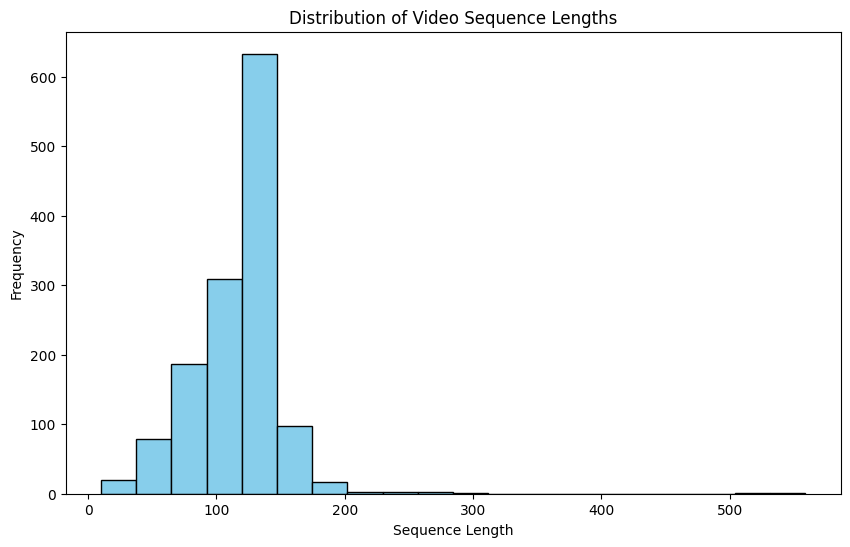

In [35]:
import matplotlib.pyplot as plt

# Assuming video_features is a list of tuples (file_path, tensor)
# Extract the sequence lengths for each video feature
sequence_lengths = [tensor.size(0) for _, tensor in video_features]

# Determine the highest and lowest sequence length
max_sequence_length = max(sequence_lengths)
min_sequence_length = min(sequence_lengths)

print(f"Maximum sequence length: {max_sequence_length}")
print(f"Minimum sequence length: {min_sequence_length}")

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Video Sequence Lengths")
plt.show()


In [36]:
# Find IMDB IDs corresponding to the maximum and minimum sequence lengths
max_length_imdbid = [imdbid for imdbid, tensor in video_features if tensor.size(0) == max_sequence_length]
min_length_imdbid = [imdbid for imdbid, tensor in video_features if tensor.size(0) == min_sequence_length]

# Output the IMDB IDs
print(f"IMDB ID(s) with maximum sequence length ({max_sequence_length}): {max_length_imdbid}")
print(f"IMDB ID(s) with minimum sequence length ({min_sequence_length}): {min_length_imdbid}")


IMDB ID(s) with maximum sequence length (559): ['../misc/video_features\\tt2370518_features.npy']
IMDB ID(s) with minimum sequence length (10): ['../misc/video_features\\tt1392197_features.npy']


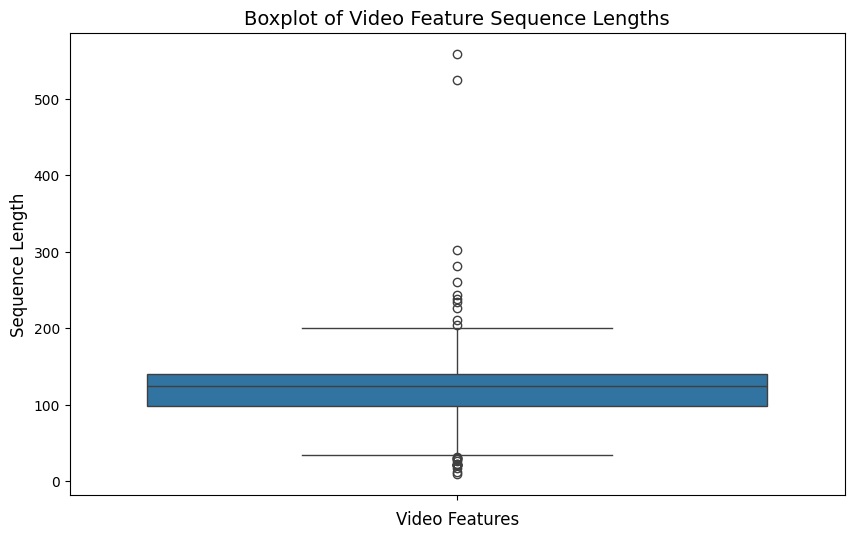

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the sequence lengths from video features
sequence_lengths = [tensor.size(0) for imdbid, tensor in video_features]

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=sequence_lengths)

# Set plot title and labels
plt.title('Boxplot of Video Feature Sequence Lengths', fontsize=14)
plt.xlabel('Video Features', fontsize=12)
plt.ylabel('Sequence Length', fontsize=12)

# Show the plot
plt.show()


In [50]:
# Calculate the Q1 (25th percentile) and Q3 (75th percentile) for sequence lengths
sequence_lengths = [tensor.size(0) for _, tensor in video_features]  # Extract sequence lengths

Q1 = np.percentile(sequence_lengths, 25)
Q3 = np.percentile(sequence_lengths, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

lower_bound = 30
upper_bound = 197

# Find the outliers
outliers = []

for file, video_tensor in video_features:
    imdbid = os.path.basename(file).split('_')[0]  # Extract IMDB ID from the file name
    seq_length = video_tensor.size(0)
    
    # Check if the sequence length is an outlier
    if seq_length < lower_bound or seq_length > upper_bound:
        outliers.append((imdbid, seq_length))

# Print outliers
print("Outliers:")
for imdbid, seq_length in outliers:
    print(f"IMDB ID: {imdbid}, Sequence Length: {seq_length}")

print("Lower Bound:", lower_bound)
print("Uppder Bound:", upper_bound)
print("Number of outliers:", len(outliers))

Outliers:
IMDB ID: tt0079540, Sequence Length: 12
IMDB ID: tt0082766, Sequence Length: 244
IMDB ID: tt0109830, Sequence Length: 227
IMDB ID: tt0115641, Sequence Length: 29
IMDB ID: tt0141369, Sequence Length: 234
IMDB ID: tt0265208, Sequence Length: 21
IMDB ID: tt0295700, Sequence Length: 21
IMDB ID: tt0301199, Sequence Length: 22
IMDB ID: tt0317648, Sequence Length: 23
IMDB ID: tt0339034, Sequence Length: 21
IMDB ID: tt0340377, Sequence Length: 22
IMDB ID: tt0409043, Sequence Length: 23
IMDB ID: tt0489225, Sequence Length: 204
IMDB ID: tt0489270, Sequence Length: 27
IMDB ID: tt0498348, Sequence Length: 29
IMDB ID: tt1232829, Sequence Length: 281
IMDB ID: tt1392197, Sequence Length: 10
IMDB ID: tt1650554, Sequence Length: 261
IMDB ID: tt1666185, Sequence Length: 524
IMDB ID: tt1878870, Sequence Length: 238
IMDB ID: tt2231461, Sequence Length: 302
IMDB ID: tt2370518, Sequence Length: 559
IMDB ID: tt2637294, Sequence Length: 200
IMDB ID: tt2870612, Sequence Length: 211
IMDB ID: tt3672742

In [28]:
def get_max_video_length(dataloader):
    max_length = 0
    
    # Loop over each batch in the DataLoader
    for _, _, _, video_data, _ in dataloader:
        # Calculate the maximum length of video sequences in the current batch
        batch_max_length = max(v.size(0) for v in video_data)
        
        # Update the overall max length if a longer sequence is found
        max_length = max(max_length, batch_max_length)
    
    return max_length

def get_min_video_length(dataloader):
    min_length = float('inf')  # Start with a very large number
    
    # Loop over each batch in the DataLoader
    for _, _, _, video_data, _ in dataloader:
        # Calculate the minimum length of video sequences in the current batch
        batch_min_length = min(v.size(0) for v in video_data)
        
        # Update the overall min length if a shorter sequence is found
        min_length = min(min_length, batch_min_length)
    
    return min_length


In [32]:
train_max_length = get_max_video_length(train_dataloader)
val_max_length = get_max_video_length(val_dataloader)
test_max_length = get_max_video_length(test_dataloader)

# Obtain the overall maximum length from the three dataloaders
overall_max_length = max(train_max_length, val_max_length, test_max_length)

# Print the maximum lengths
print(f"Train dataset maximum video length: {train_max_length}")
print(f"Validation dataset maximum video length: {val_max_length}")
print(f"Test dataset maximum video length: {test_max_length}")

print(f"Overall maximum video length: {overall_max_length}")

print('-'*50)

train_min_length = get_min_video_length(train_dataloader)
val_min_length = get_min_video_length(val_dataloader)
test_min_length = get_min_video_length(test_dataloader)

# Obtain the overall minimum length from the three dataloaders
overall_min_length = min(train_min_length, val_min_length, test_min_length)

# Print the minimum lengths
print(f"Train dataset minimum video length: {train_min_length}")
print(f"Validation dataset minimum video length: {val_min_length}")
print(f"Test dataset minimum video length: {test_min_length}")

print(f"Overall minimum video length: {overall_min_length}")

Train dataset maximum video length: 197
Validation dataset maximum video length: 197
Test dataset maximum video length: 197
Overall maximum video length: 197
--------------------------------------------------
Train dataset minimum video length: 197
Validation dataset minimum video length: 197
Test dataset minimum video length: 197
Overall minimum video length: 197


In [30]:
def print_video_feature_shapes(dataloader):
    for batch_idx, (_, _, _, video_data, _) in enumerate(dataloader):
        print(f"Batch {batch_idx + 1}:")
        for i, video_tensor in enumerate(video_data):
            print(f"  Video {i + 1} shape: {video_tensor.shape}")
        print("-" * 40)

# Use the function for each dataloader to print shapes
print("Train Dataloader Video Shapes:")
print_video_feature_shapes(train_dataloader)

print("\nValidation Dataloader Video Shapes:")
print_video_feature_shapes(val_dataloader)

print("\nTest Dataloader Video Shapes:")
print_video_feature_shapes(test_dataloader)


Train Dataloader Video Shapes:
Batch 1:
  Video 1 shape: torch.Size([197, 768])
  Video 2 shape: torch.Size([197, 768])
  Video 3 shape: torch.Size([197, 768])
  Video 4 shape: torch.Size([197, 768])
  Video 5 shape: torch.Size([197, 768])
  Video 6 shape: torch.Size([197, 768])
  Video 7 shape: torch.Size([197, 768])
  Video 8 shape: torch.Size([197, 768])
  Video 9 shape: torch.Size([197, 768])
  Video 10 shape: torch.Size([197, 768])
  Video 11 shape: torch.Size([197, 768])
  Video 12 shape: torch.Size([197, 768])
  Video 13 shape: torch.Size([197, 768])
  Video 14 shape: torch.Size([197, 768])
  Video 15 shape: torch.Size([197, 768])
  Video 16 shape: torch.Size([197, 768])
  Video 17 shape: torch.Size([197, 768])
  Video 18 shape: torch.Size([197, 768])
  Video 19 shape: torch.Size([197, 768])
  Video 20 shape: torch.Size([197, 768])
  Video 21 shape: torch.Size([197, 768])
  Video 22 shape: torch.Size([197, 768])
  Video 23 shape: torch.Size([197, 768])
  Video 24 shape: torch.Si

### Model Class

In [8]:
## MCA Class
class MutualCrossAttention(nn.Module):
    def __init__(self, dropout):
        super(MutualCrossAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(768).to(device)
        self.device = device

    def forward(self, x1, x2):
        # Move x1 and x2 to the correct device
        x1, x2 = x1.to(self.device), x2.to(self.device)

        # Assign x1 and x2 to query and key
        query = x1
        key = x2
        d = query.shape[-1]

        # Basic attention mechanism formula to get intermediate output A
        scores = torch.bmm(query, key.transpose(1, 2)) / math.sqrt(d)
        output_A = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x2)
        # Basic attention mechanism formula to get intermediate output B
        scores = torch.bmm(key, query.transpose(1, 2)) / math.sqrt(d)
        output_B = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x1)

        # Make the summation of the two intermediate outputs
        output = output_A + output_B  # shape (1280, 32, 60)

        output = self.layer_norm(output)

        return output

### SMCA Functions and Model

In [9]:
def SMCAStage1(modalityAlpha, modalityBeta, d_out_kq, d_out_v, device):
    
    cross_attn = MutualCrossAttention(att_dropout_rate)

    # Cross-attention: Alpha + Beta
    alphaBeta = cross_attn(modalityAlpha, modalityBeta)  # Shape: (batch_size, num_queries, d_out_v)

    # Concatenate cross-attention outputs along the feature dimension (-1)
    return alphaBeta

In [10]:
def SMCAStage2(modalityAlphaBeta, modalityGamma, d_out_kq, d_out_v, device):
    # modalityAlphaBeta: (batch_size, seq_len, 2 * d_out_v) [output of Stage 1]

    cross_attn = MutualCrossAttention(att_dropout_rate)

    alphaBetaGamma = cross_attn(modalityAlphaBeta, modalityGamma)  # Shape: (batch_size, seq_len_alphaBeta, d_out_v)

    return alphaBetaGamma

In [11]:
class SMCAModel(nn.Module):
    def __init__(self, d_out_kq, d_out_v, device):
        super(SMCAModel, self).__init__()
        self.d_out_kq = d_out_kq
        self.d_out_v = d_out_v
        self.device = device
    
    def forward(self, modalityAlpha, modalityBeta, modalityGamma):
        # Stage 1: Cross attention between modalityAlpha and modalityBeta
        modalityAlphaBeta = SMCAStage1(modalityAlpha, modalityBeta, self.d_out_kq, self.d_out_v, self.device)

        # Stage 2: Cross attention with modalityAlphaBeta (as query) and modalityGamma (as key-value)
        multimodal_representation = SMCAStage2(modalityAlphaBeta, modalityGamma, self.d_out_kq, self.d_out_v, self.device)

        return multimodal_representation

### Model Training Functions

In [12]:
def train_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    optimizer, 
    device,
    output_dir='results/', 
    output_filename='train_predictions.csv',
    output_dim=768
):
    # model.train()
    dense_layer.train()
    total_loss = 0.0
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    # List to collect results for CSV
    results = []
    
    print("-" * 20, "Train", "-" * 20)

    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        text_features, audio_features, video_features, targets = (
            text_features.to(device),
            audio_features.to(device),
            video_features.to(device),
            targets.to(device).view(-1)
        )
                
        # Squeeze the audio features to remove the extra dimension
        audio_features = audio_features.squeeze(1).to(device) 
        text_features = text_features.unsqueeze(1).to(device) 

        # Apply linear transformations to match dimensions
        linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
        text_features = linear_transform_text(text_features).to(device) 
    
        transformed_features = {
            'audio_features': audio_features,
            'text_features': text_features,
            'video_features': video_features
        }

        outputs = model(
            modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device) ,  # Use the dictionary for modality assignment
            modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device) ,
            modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device) 
        ).to(device)

        outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 190*768]

        # Pass the fused features through the dense layer
        predictions = dense_layer(outputs).view(-1)

        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # !!!Apply if BCEWithLogits or CustomLoss!!!
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)

        # Apply threshold to get binary predictions
        preds = (predictions >= threshold).float()
        
        # Collect results for each sample
        for i in range(len(imdbids)):
            results.append({
                'IMDBid': imdbids[i],
                'Raw Prediction': predictions[i].item(),
                'Binary Prediction': preds[i].item(),
                'Target': targets[i].item()
            })
        
        # Update metrics for binary classification
        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()  # Compute accuracy
    
    train_average_loss = total_loss / len(dataloader)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Precision: {train_precision:.4f}")
    print(f"Train Recall: {train_recall:.4f}")
    print(f"Train F1 Score: {train_f1_score:.4f}")
    print(f"Train Loss: {train_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score

In [13]:
def evaluate_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/', 
    output_filename='val_predictions.csv',
    output_dim=768
):
    model.eval()
    dense_layer.eval()
    total_loss = 0.0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    
    print("-" * 20, "Eval", "-" * 20)
    
    with torch.no_grad():
         for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
        
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device)
            text_features = text_features.unsqueeze(1).to(device)

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)   
            text_features = linear_transform_text(text_features).to(device)
                                    
            transformed_features = {
                'audio_features': audio_features,
                'text_features': text_features,
                'video_features': video_features
            }

            outputs = model(
                modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device),  # Use the dictionary for modality assignment
                modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device),
                modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device)
            )
            
            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1_score = f1_metric.compute().item()
    val_accuracy = accuracy_metric.compute().item() 
    
    # Calculate confusion matrix
    val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    val_average_loss = total_loss / len(dataloader)
    print(f"Eval Accuracy: {val_accuracy:.4f}")
    print(f"Eval Precision: {val_precision:.4f}")
    print(f"Eval Recall: {val_recall:.4f}")
    print(f"Eval F1 Score: {val_f1_score:.4f}")
    print(f"Eval Loss: {val_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)
    
    return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix

In [14]:
def test_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/', 
    output_filename='test_predictions.csv',
    output_dim=768
):
    model.eval()
    dense_layer.eval()
    total_loss = 0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 

    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    
    print("-" * 20, "Test", "-" * 20)

    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
            
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device) 
            text_features = text_features.unsqueeze(1).to(device) 

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
            text_features = linear_transform_text(text_features).to(device) 
                
            transformed_features = {
                'audio_features': audio_features,
                'text_features': text_features,
                'video_features': video_features
            }

            outputs = model(
                modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device) ,  # Use the dictionary for modality assignment
                modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device) ,
                modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device) 
            )
    
            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)
                
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            # Collect predictions and targets for the confusion matrix
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

     # Compute average precision, recall, F1 score, and accuracy
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item()
    
    # Generate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, all_predictions)

    test_average_loss = total_loss / len(dataloader)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix

In [15]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

### Classifier

In [16]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=cl_dropout_rate):
        super(FinalClassifier, self).__init__()
        # 145920-3072-768-1
        self.fc1 = nn.Linear(input_size, 3072)  # First fully connected layer
        self.fc2 = nn.Linear(3072, 768)          # Second fully connected layer
        # self.fc3 = nn.Linear(3072, 768)          # Third fully connected layer
        # self.fc4 = nn.Linear(128, 64)          # Second fully connected layer

        self.dropout = nn.Dropout(dropout_rate) # Dropout layer
        self.dense = nn.Linear(768, 1)          # Final dense layer for binary classification
        self.relu = nn.ReLU()                    # ReLU activation
        self.sigmoid = nn.Sigmoid()              # Sigmoid activation for final output

    def forward(self, x):
        x = self.fc1(x)                         # First fully connected layer
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc2(x)                         # second fully connected layer
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        # x = self.fc3(x)                         # third fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation

        # x = self.fc4(x)                         # fourth fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation
        # x = self.dropout(x)                     # Apply dropout
        
        x = self.dense(x)                       # Final dense layer
        if isBCELoss:
            x = self.sigmoid(x)                  # Apply sigmoid activation
        return x                                 # Output probabilities for BCELoss


### Model Training

In [17]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [18]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [19]:
if __name__ == "__main__":
    torch.manual_seed(42)

    # Initialize the SMCA model A
    model = SMCAModel(768, 768, device).to(device)  # Dimension for d_out_kq and d_out_v

    # Determine the output dimensions
    output_dim = 768

    # Own DenseLayer or FinalClassifier
    if isFinalClassifier:
        dense_layer = FinalClassifier(197 * output_dim).to(device) 
    else:
        dense_layer = DenseLayer(197 * output_dim).to(device)

    optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)

    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device, output_dim=output_dim)
        train_losses.append(train_average_loss)  # Store training loss
        
        for name, param in model.named_parameters():
            if param.grad is None:
                print("After train: model:", "No gradient for:", name)
        
        for name, param in dense_layer.named_parameters():
            if param.grad is None:
                print("After train: classifier:", "No gradient for:", name)

        # Validate step
        eval_average_loss, eval_accuracy, eval_precision, eval_recall, eval_f1_score, eval_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device, output_dim=output_dim)
        val_losses.append(eval_average_loss)  # Store validation loss
        
        # print(f"Training Loss: {train_average_loss:.4f}, Validation Loss: {eval_average_loss:.4f}")

    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device, output_dim=output_dim)
    
    # Summary of metrics
    metrics_summary = {
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [eval_accuracy],
        "Test Accuracy": [test_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [eval_precision],
        "Test Precision": [test_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [eval_recall],
        "Test Recall": [test_recall],
        "Train F1 Score": [train_f1_score],
        "Validation F1 Score": [eval_f1_score],
        "Test F1 Score": [test_f1_score],
        "Train Loss": [train_average_loss],
        "Validation Loss": [eval_average_loss],
        "Test Loss": [test_average_loss]
    }
    
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_summary)
    

----------------------------------------
Epoch 1/10
-------------------- Train --------------------
Train Accuracy: 0.6008
Train Precision: 0.3417
Train Recall: 0.6208
Train F1 Score: 0.4408
Train Loss: 0.9789
-------------------- Eval --------------------
Eval Accuracy: 0.7586
Eval Precision: 0.5484
Eval Recall: 0.3269
Eval F1 Score: 0.4096
Eval Loss: 1.0297
----------------------------------------
Epoch 2/10
-------------------- Train --------------------
Train Accuracy: 0.6748
Train Precision: 0.4124
Train Recall: 0.6667
Train F1 Score: 0.5096
Train Loss: 0.9215
-------------------- Eval --------------------
Eval Accuracy: 0.7340
Eval Precision: 0.4848
Eval Recall: 0.6154
Eval F1 Score: 0.5424
Eval Loss: 0.8745
----------------------------------------
Epoch 3/10
-------------------- Train --------------------
Train Accuracy: 0.6610
Train Precision: 0.3975
Train Recall: 0.6542
Train F1 Score: 0.4945
Train Loss: 0.9212
-------------------- Eval --------------------
Eval Accuracy: 0.67

### Results Monitoring

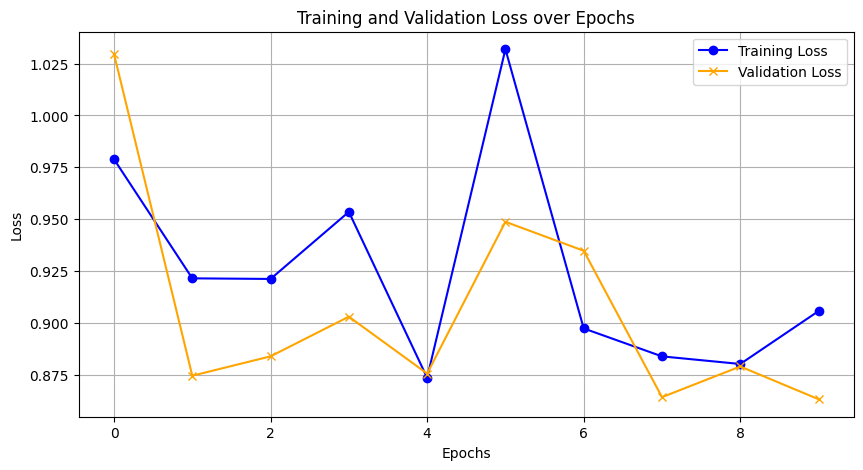

In [20]:
plot_losses(train_losses, val_losses)

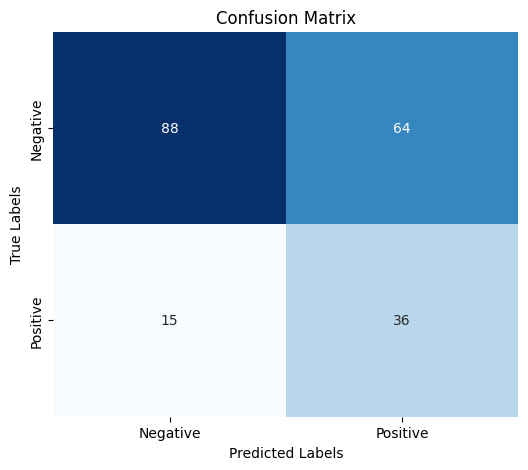

In [21]:
plot_confusion_matrix(test_conf_matrix)

In [22]:
# Display the table
metrics_df

,Train Accuracy,Validation Accuracy,Test Accuracy,Train Precision,Validation Precision,Test Precision,Train Recall,Validation Recall,Test Recall,Train F1 Score,Validation F1 Score,Test F1 Score,Train Loss,Validation Loss,Test Loss
0,0.696938,0.665025,0.610837,0.433428,0.414894,0.36,0.6375,0.75,0.705882,0.51602,0.534247,0.476821,0.9057,0.863206,0.94104


In [23]:
# Print sizes of each DataLoader (FOR CHECKING)
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")


Train DataLoader: Total Samples = 947, Number of Batches = 30
Validation DataLoader: Total Samples = 203, Number of Batches = 13
Test DataLoader: Total Samples = 203, Number of Batches = 13


In [24]:
train_df = pd.read_csv('results/train_predictions.csv')
train_df


,IMDBid,Raw Prediction,Binary Prediction,Target
0,tt2393845,0.480178,0.0,1.0
1,tt0796375,0.516977,1.0,0.0
2,tt2207484,0.795294,1.0,1.0
3,tt0252444,0.244747,0.0,0.0
4,tt0246464,0.556125,1.0,0.0
...,...,...,...,...
942,tt1205558,0.375385,0.0,1.0
943,tt0204175,0.332115,0.0,0.0
944,tt1060277,0.808566,1.0,0.0
945,tt0109830,0.260729,0.0,0.0


In [25]:
eval_df = pd.read_csv('results/val_predictions.csv')
eval_df

,IMDBid,Raw Prediction,Binary Prediction,Target
0,tt0337711,0.461271,0.0,0.0
1,tt0963194,0.538412,1.0,0.0
2,tt0107048,0.369498,0.0,0.0
3,tt0758774,0.582668,1.0,0.0
4,tt0117496,0.770259,1.0,0.0
...,...,...,...,...
198,tt0118663,0.168857,0.0,0.0
199,tt0478087,0.330493,0.0,0.0
200,tt0888693,0.063195,0.0,0.0
201,tt0074991,0.216219,0.0,0.0


In [26]:
test_df = pd.read_csv('results/test_predictions.csv')
test_df

,IMDBid,Raw Prediction,Binary Prediction,Target
0,tt10740584,0.510751,1.0,1.0
1,tt0815245,0.549844,1.0,0.0
2,tt0996979,0.631582,1.0,0.0
3,tt1155056,0.597241,1.0,1.0
4,tt4273562,0.400884,0.0,0.0
...,...,...,...,...
198,tt0844671,0.492871,0.0,0.0
199,tt3152624,0.779426,1.0,1.0
200,tt0800241,0.388647,0.0,0.0
201,tt1798603,0.535309,1.0,1.0
